# First test

In [3]:
# libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import sys

In [4]:
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

Create function with no inputs that samples from wavespeed distribution (currently fixed) and chooses a wavespeed, and then propagates the intial conditions (fixed) forward in time.

In [39]:
def wave():
    """ no input params at the moment """
    # basic parameters (fixed)
    nx = 41  # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2 / (nx-1)
    nt = 25    #nt is the number of timesteps we want to calculate
    dt = .025  #dt is the amount of time each timestep covers (delta t)
    c = 1
    # initial conditions
    u = torch.ones(nx)     
    u[int(.5 / dx):int(1 / dx + 1)] = 2  # set u = 2 between 0.5 and 1 
    plt.plot(np.linspace(0, 2, nx), u.numpy());
    
    # get pyro distribution of speed
    speed = pyro.sample("speed", dist.Normal(c, 0.25))
    print(speed)

    # propagate in time for nt steps, un is the next step
    un = torch.zeros(nx)
    for n in range(nt): 
        un[0]= u[0]
        un[1:] = u[1:] - speed * dt / dx * (u[1:] - u[0:-1])
        # set u to un for next iteration
        u = un
    
    plt.plot(np.linspace(0, 2, nx), u.numpy());
    #speed = pyro.param("speed",speed)
    [pyro.param("u_{}".format(str(i)),u[i]) for i in range(nx)]

    return(u)




tensor(0.7882)


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0001, 1.0005, 1.0028, 1.0110, 1.0335, 1.0822, 1.1682,
        1.2940, 1.4485, 1.6094, 1.7521, 1.8603, 1.9303, 1.9672, 1.9777, 1.9629,
        1.9168, 1.8316, 1.7060, 1.5514, 1.3906, 1.2479, 1.1396, 1.0692, 1.0299,
        1.0112, 1.0036, 1.0010, 1.0002, 1.0000])

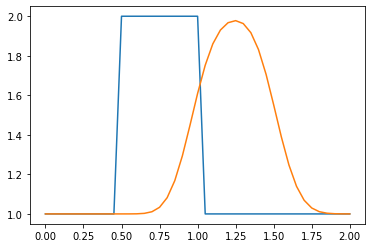

In [40]:
wave()

tensor(0.7163)
tensor(1.0502)
tensor(1.1050)
tensor(1.2601)
tensor(1.1870)


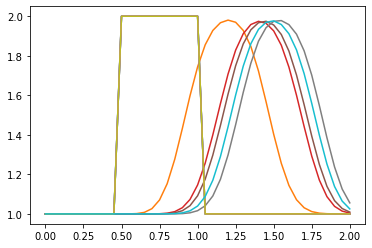

In [136]:
# Check this gives a different position wave every time depending on the speed sampled
for i in range(5):
    wave()

We observe wave speed of speed_observed and put this into the function to create the guide

In [137]:
speed_observed = 0.5

In [138]:
conditioned_wave = pyro.condition(wave, data={"speed": speed_observed})

0.5
0.5
0.5
0.5
0.5


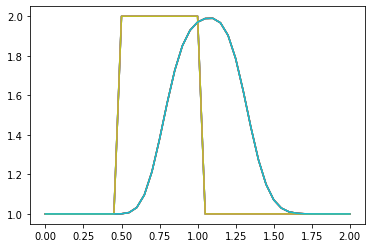

In [139]:
# Check this gives the same position wave every time as we have observed speed at 0.5
for i in range(5):
    u_observed = conditioned_wave()

What if we condition on wave output, can we get the wave speed needed to get this output (using fixed wave speed from before, the correct value should be 0.5)?

In [48]:
u_observed

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0008, 1.0070, 1.0321, 1.0962, 1.2137, 1.3783, 1.5611, 1.7265,
        1.8506, 1.9287, 1.9703, 1.9885, 1.9896, 1.9670, 1.9036, 1.7862, 1.6217,
        1.4389, 1.2735, 1.1494, 1.0713, 1.0297, 1.0107, 1.0034, 1.0009, 1.0002,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [49]:
speed_observed = 0.  # set this so it doesn't stay at 0.5 

In [50]:
#conditioned_wave = pyro.condition(wave, data={"u": u_observed}) 

In [51]:
#for i in range(5):
#    conditioned_wave()
# Check these should give back the same shape wave since it is fixed in conditioned_wave

In [83]:
param_store = pyro.get_param_store()
param_store.named_parameters()

dict_items([('u_0', tensor(1., requires_grad=True)), ('u_1', tensor(1., requires_grad=True)), ('u_2', tensor(1., requires_grad=True)), ('u_3', tensor(1., requires_grad=True)), ('u_4', tensor(1., requires_grad=True)), ('u_5', tensor(1., requires_grad=True)), ('u_6', tensor(1., requires_grad=True)), ('u_7', tensor(1., requires_grad=True)), ('u_8', tensor(1., requires_grad=True)), ('u_9', tensor(1., requires_grad=True)), ('u_10', tensor(1., requires_grad=True)), ('u_11', tensor(1.0000, requires_grad=True)), ('u_12', tensor(1.0000, requires_grad=True)), ('u_13', tensor(1.0000, requires_grad=True)), ('u_14', tensor(1.0001, requires_grad=True)), ('u_15', tensor(1.0005, requires_grad=True)), ('u_16', tensor(1.0023, requires_grad=True)), ('u_17', tensor(1.0077, requires_grad=True)), ('u_18', tensor(1.0221, requires_grad=True)), ('u_19', tensor(1.0541, requires_grad=True)), ('u_20', tensor(1.1143, requires_grad=True)), ('u_21', tensor(1.2106, requires_grad=True)), ('u_22', tensor(1.3425, requir

In [116]:
from torch.distributions import constraints

def wave_parametrized_guide():
    # basic parameters (fixed)
    nx = 41  # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2 / (nx-1)
    nt = 25    #nt is the number of timesteps we want to calculate
    dt = .025  #dt is the amount of time each timestep covers (delta t)
    c = 1
    # Choose each point on wave to be from random normal 
    a = 1
    b = 0.5
    # initial conditions
    u = torch.ones(nx)
    for i in range(nx):
        a_i = pyro.param("a_{}".format(str(i)), torch.tensor(1.))
        b_i = pyro.param("b_{}".format(str(i)), torch.tensor(0.5), 
                         constraint=constraints.positive)


        u[i] = pyro.sample("u_{}".format(str(i)), dist.Normal(a_i,b_i))
    #plt.plot(np.linspace(0,2,nx),u.numpy())    
    return u

In [96]:
wave_parametrized_guide()

tensor([ 1.0798,  1.0575,  1.2576,  1.3848,  1.3419,  0.9199,  0.7954,  1.3988,
         0.9083,  0.7863,  0.5170,  0.0711,  1.2581,  1.7443, -0.0781,  1.0807,
         0.7818,  1.5797,  0.6129,  1.2363,  1.6450,  1.1217,  1.4530,  1.6025,
         0.5548,  0.5620,  1.0690,  1.2204,  0.7351,  0.5121,  1.1015,  2.3251,
         1.5038,  0.3734,  1.7894,  1.4850, -0.2506,  1.3193, -0.0909,  1.6879,
         0.9435], grad_fn=<CopySlices>)

In [97]:
param_store.get_param("u_0")

tensor(1., requires_grad=True)

tensor(1.4045)
tensor(0.9870)
tensor(0.8803)
tensor(1.3303)
tensor(1.4035)
tensor(0.6821)
tensor(1.2980)
tensor(0.7551)
tensor(1.4316)
tensor(0.7853)
tensor(1.5707)
tensor(1.0116)
tensor(1.1245)
tensor(1.0057)
tensor(0.8889)
tensor(0.8281)
tensor(0.8417)
tensor(0.6680)
tensor(1.3220)
tensor(0.9551)
tensor(1.4603)
tensor(0.9540)
tensor(0.9812)
tensor(0.8127)
tensor(0.6100)
tensor(1.1865)
tensor(0.8806)
tensor(1.0227)
tensor(0.8871)
tensor(1.3987)
tensor(1.1530)
tensor(0.8998)
tensor(1.1428)
tensor(1.0740)
tensor(0.8780)
tensor(0.9476)
tensor(1.0022)
tensor(0.7460)
tensor(1.0777)
tensor(0.8852)
tensor(0.8669)
tensor(1.0278)
tensor(0.9522)
tensor(0.9327)
tensor(1.2747)
tensor(1.0017)
tensor(0.7586)
tensor(1.4138)
tensor(0.9338)
tensor(0.5937)
tensor(0.7729)
tensor(0.9428)
tensor(0.7740)
tensor(0.6381)
tensor(1.0074)
tensor(0.8844)
tensor(1.3202)
tensor(1.3881)
tensor(0.7013)
tensor(0.5071)
tensor(0.6278)
tensor(1.1426)
tensor(0.8418)
tensor(0.7503)
tensor(0.9178)
tensor(0.7795)
tensor(1.0

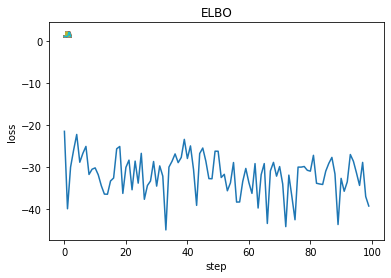

In [130]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=wave, 
                     guide=wave_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 100
for t in range(num_steps):
    losses.append(svi.step())
    a.append(pyro.param("a_10").item())
    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");


In [131]:
print(a)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [132]:
nx=41
u =  torch.tensor([param_store.get_param("u_{}".format(str(i))) for i in range(nx)] )

In [133]:
u

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0001, 1.0004, 1.0016, 1.0056, 1.0164, 1.0419, 1.0935, 1.1827, 1.3142,
        1.4783, 1.6504, 1.7998, 1.9052, 1.9634, 1.9849, 1.9819, 1.9579, 1.9065,
        1.8173, 1.6858, 1.5217, 1.3496, 1.2001])

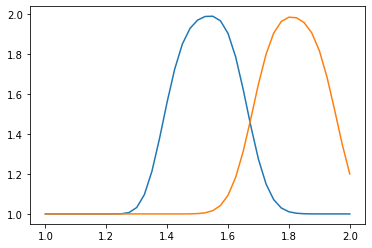

In [135]:
plt.plot(np.linspace(1,2,nx),u_observed.numpy());
plt.plot(np.linspace(1,2,nx),u.numpy());

In [124]:
param_store = pyro.get_param_store()

In [125]:
param_store.get_param("u_0")

tensor(1., requires_grad=True)

In [126]:
print(u)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0008, 1.0070, 1.0321, 1.0962, 1.2137, 1.3783, 1.5611, 1.7265,
        1.8506, 1.9287, 1.9703, 1.9885, 1.9896, 1.9670, 1.9036, 1.7862, 1.6217,
        1.4389, 1.2735, 1.1494, 1.0713, 1.0297, 1.0107, 1.0034, 1.0009, 1.0002,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [127]:
print(u_observed)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0008, 1.0070, 1.0321, 1.0962, 1.2137, 1.3783, 1.5611, 1.7265,
        1.8506, 1.9287, 1.9703, 1.9885, 1.9896, 1.9670, 1.9036, 1.7862, 1.6217,
        1.4389, 1.2735, 1.1494, 1.0713, 1.0297, 1.0107, 1.0034, 1.0009, 1.0002,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [128]:
a= torch.tensor([param_store.get_param("a_{}".format(str(i))) for i in range(nx)] )
b= torch.tensor([param_store.get_param("b_{}".format(str(i))) for i in range(nx)] )
print(a)
print(b)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.])
tensor([0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587,
        0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587,
        0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587,
        0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587, 0.5587,
        0.5587, 0.5587, 0.5587, 0.5587, 0.5587])
